In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires transformers>=4.33.1, but you have transformers 4.28.0 which is incompatible.


In [3]:
num_images_per_category = 500 #5000
k = 0 #0-9

In [4]:
import os
import shutil

source_dir = "/kaggle/input/cifar10-pngs-in-folders/cifar10/train/"
destination_dir = "/kaggle/working/cifar10-pngs-in-folders/cifar10/train/"

# Create destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

folders = os.listdir(source_dir)
# Sort the folders based on their names
folders.sort()

# Iterate through each folder and copy images
for folder in folders:
    # Construct the path to the current folder
    folder_path = os.path.join(source_dir, folder)
    # Check if the folder exists and is a directory
    if os.path.isdir(folder_path):
        # List all files in the folder
        files = os.listdir(folder_path)
        # Sort the files based on their names
        files.sort()
        # Iterate through the files and copy the first num_images_per_category files
        for i in range(num_images_per_category*k,num_images_per_category*(k+1),1):
            # Construct the path to the current file
            file_path = os.path.join(folder_path, files[i])
            # Construct the destination path for the file
            dest_path = os.path.join(destination_dir, folder)
            # Create the destination folder if it doesn't exist
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            # Copy the file to the destination folder
            shutil.copy(file_path, dest_path)

In [5]:
train_path = "/kaggle/working/cifar10-pngs-in-folders/cifar10/train/"
test_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/test/"

In [6]:
from datasets import load_dataset

train_dataset = load_dataset("imagefolder", data_dir=train_path, drop_labels=False,split="train")
test_dataset = load_dataset("imagefolder", data_dir=test_path, drop_labels=False, split="train")

Resolving data files:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

In [8]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

['airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane']


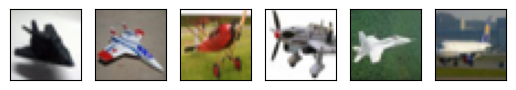

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
print([train_dataset.features["label"].names[x] for x in train_dataset[:6]["label"]])
show(train_dataset[:6]["image"])

In [10]:
from datasets import DatasetDict

train_valid = train_dataset.train_test_split(test_size=0.1)

train_dataset = train_valid["train"]
valid_dataset = train_valid["test"]
test_dataset = test_dataset

In [11]:
train_dataset.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
from transformers import ViTImageProcessor
imagePreprocessing = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

2024-04-25 12:37:47.400850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 12:37:47.400961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 12:37:47.534550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [13]:
# from transformers import BeitImageProcessor
# imagePreprocessing = BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")

In [14]:
imagePreprocessing

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [15]:
# Create image augmentation for training

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomRotation,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=imagePreprocessing.image_mean, std=imagePreprocessing.image_std)
size = (imagePreprocessing.size["height"], imagePreprocessing.size["width"])
cropSize = size

trainingTransforms = Compose([
    Resize(size),
    CenterCrop(cropSize),
    RandomRotation(180),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ToTensor(),
    normalize
])

In [16]:
import torch

def training_image_processing(batch):
    batch["pixel_values"] = torch.stack([trainingTransforms(img) for img in batch["image"]])
    return batch


def process_image_batch(batch):
    res = imagePreprocessing([img for img in batch["image"]], return_tensors="pt")
    res["label"] = batch["label"]
    return res

In [17]:
train_dataset = train_dataset.with_transform(training_image_processing)
valid_dataset = valid_dataset.with_transform(process_image_batch)
test_dataset = test_dataset.with_transform(process_image_batch)

In [18]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x["pixel_values"] for x in batch]),
        'labels': torch.tensor([x["label"] for x in batch])
    }

In [19]:
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_24/2127246122.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [20]:
from transformers import ViTForImageClassification

labels = train_dataset.features["label"].names

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# from transformers import BeitForImageClassification

# labels = train_dataset.features["label"].names

# id_to_label = {i: label for i, label in enumerate(labels)}
# label_to_id = {label: i for i, label in enumerate(labels)}

# model = BeitForImageClassification.from_pretrained(
#     "microsoft/beit-base-patch16-224-pt22k-ft22k",
#     num_labels=len(labels),
#     id2label=id_to_label,
#     label2id=label_to_id,
#     ignore_mismatched_sizes=True
# )

In [22]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./train_output",
    remove_unused_columns=False,
    per_device_train_batch_size=32,
    fp16=True,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    save_steps=30,
    save_total_limit=2,
    logging_steps=10,
    num_train_epochs=30,
    report_to="none",
#     push_to_hub=True
)

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=imagePreprocessing,
)

In [24]:
train_results = trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,2.284200,2.280437,0.180000
20,2.211900,2.241369,0.286000
30,2.085900,2.179338,0.464000
40,1.950600,2.099131,0.560000
50,1.842200,2.004832,0.640000
60,1.721200,1.902266,0.692000
70,1.610600,1.822096,0.730000
80,1.482600,1.787943,0.748000
90,1.405800,1.673012,0.724000
100,1.323400,1.591771,0.750000


In [25]:
metrics = trainer.evaluate(test_dataset)
metrics
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       30.0
  eval_accuracy           =     0.9562
  eval_loss               =     0.1873
  eval_runtime            = 0:02:32.73
  eval_samples_per_second =     65.472
  eval_steps_per_second   =      8.184


In [26]:
model.save_pretrained("/kaggle/working/checkpoint/")

In [27]:
model.from_pretrained("/kaggle/working/checkpoint/")

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [28]:
batch_size = 16  # Adjust this to a smaller value
num_batches = len(test_dataset) // batch_size
true_y = []
pred_y = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    
    batch = test_dataset[start_idx:end_idx]
    true_y = true_y + batch["label"]
    test = batch["pixel_values"]

    with torch.no_grad():
        test = test.cuda()
        pred_y  = pred_y + model(test).logits.argmax(-1).cpu().tolist()

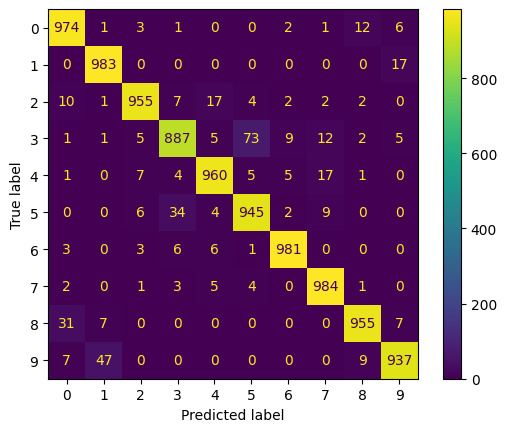

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_y, pred_y)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Save the plot as an image
plt.savefig('Vit_confusion_matrix.png')

In [30]:
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y,target_names=labels,digits=4))

              precision    recall  f1-score   support

    airplane     0.9466    0.9740    0.9601      1000
  automobile     0.9452    0.9830    0.9637      1000
        bird     0.9745    0.9550    0.9646      1000
         cat     0.9416    0.8870    0.9135      1000
        deer     0.9629    0.9600    0.9614      1000
         dog     0.9157    0.9450    0.9301      1000
        frog     0.9800    0.9810    0.9805      1000
       horse     0.9600    0.9840    0.9719      1000
        ship     0.9725    0.9550    0.9637      1000
       truck     0.9640    0.9370    0.9503      1000

    accuracy                         0.9561     10000
   macro avg     0.9563    0.9561    0.9560     10000
weighted avg     0.9563    0.9561    0.9560     10000

